# !!! MAKE SURE TF VERSION IS THE SAME WHEN TESTING ON LOCAL MACHINE !!!

In [1]:
import tensorflow as tf
tf.__version__

'2.18.0'

# * Import needed modules, for local and for Colab

In [2]:
# Import system libs
import os
import time
import shutil
import pathlib
import itertools

# Import data handling libs
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import machine learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# * Clone dataset from uploaded GitHub

In [3]:
# ? This dataset clone is pre-split using sklearn, no need to add splitting

!git clone https://github.com/GitKentC/covid_dataset.git

fatal: destination path 'covid_dataset' already exists and is not an empty directory.


# Load dataset as generators

In [4]:
TRAIN_DIR = f'/content/covid_dataset/split_dataset/train'
VALIDATION_DIR = f'/content/covid_dataset/split_dataset/validation'
TEST_DIR = f'/content/covid_dataset/split_dataset/test'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

"""
On this project, generator were used to handle RAM usage crash.
It basically load one batch at a time from the dataframe instead of loading all at once
to speedup training.
"""

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'  # accepts 'grayscale', 'rgb', and 'rgba' only
SEED = 42

def preprocess(image):
    """
    Preprocessing function: Resize and normalize the images
    PREPROCESS_INPUT_MODE_DOC =
    mode: One of "caffe", "tf" or "torch".
      - caffe: will convert the images from RGB to BGR,
          then will zero-center each color channel with
          respect to the ImageNet dataset,
          without scaling.
      - tf: will scale pixels between -1 and 1,
          sample-wise.
      - torch: will scale pixels between 0 and 1 and then
          will normalize each channel with respect to the
          ImageNet dataset.
      Defaults to `"caffe"`.

      Note: each Keras Application expects a specific kind of input preprocessing.
      For MobileNetV3, by default input preprocessing is included as a part of the
      model (as a `Rescaling` layer), and thus
      `keras.applications.mobilenet_v3.preprocess_input` is actually a
      pass-through function. In this use case, MobileNetV3 models expect their
      inputs to be float tensors of pixels with values in the `[0-255]` range.
      At the same time, preprocessing as a part of the model (i.e. `Rescaling`
      layer) can be disabled by setting `include_preprocessing` argument to `False`.
      With preprocessing disabled MobileNetV3 models expect their inputs to be float
      tensors of pixels with values in the `[-1, 1]` range.
    """
    # # image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=True)  # Resize to 224x224
    # image = tf.cast(image, tf.float32)  # Convert to float32
    # image = (image / 127.5) - 1  # Normalize to [-1, 1] range
    return image

def create_gens():
    """ Function to load from pre-split dataset directories using ImageDataGenerator with preprocessing """

    # Initialize the ImageDataGenerator without validation split but with preprocessing function
    tr_gen = ImageDataGenerator(
        preprocessing_function=preprocess,
        horizontal_flip=True
    )
    ts_gen = ImageDataGenerator(
        preprocessing_function=preprocess
    )

    # Train Generator (from the pre-split training directory)
    train_generator = tr_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        seed=SEED,
        shuffle=True
    )

    # Validation Generator (from the pre-split validation directory)
    validation_generator = ts_gen.flow_from_directory(
        VALIDATION_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        seed=SEED,
        shuffle=True
    )

    # Test Generator (from the pre-split test directory)
    test_generator = ts_gen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        seed=SEED,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator


In [6]:
""" Create datasets """
# train_ds, val_ds = load_datasets_cleaned()
# train_ds, val_ds, test_ds = load_datasets_split()
train_gen, val_gen, test_gen = create_gens()

Found 14814 images belonging to 4 classes.
Found 4252 images belonging to 4 classes.
Found 2099 images belonging to 4 classes.


In [7]:
print(train_gen.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


## Sanity check for images, (reverse preprocess)

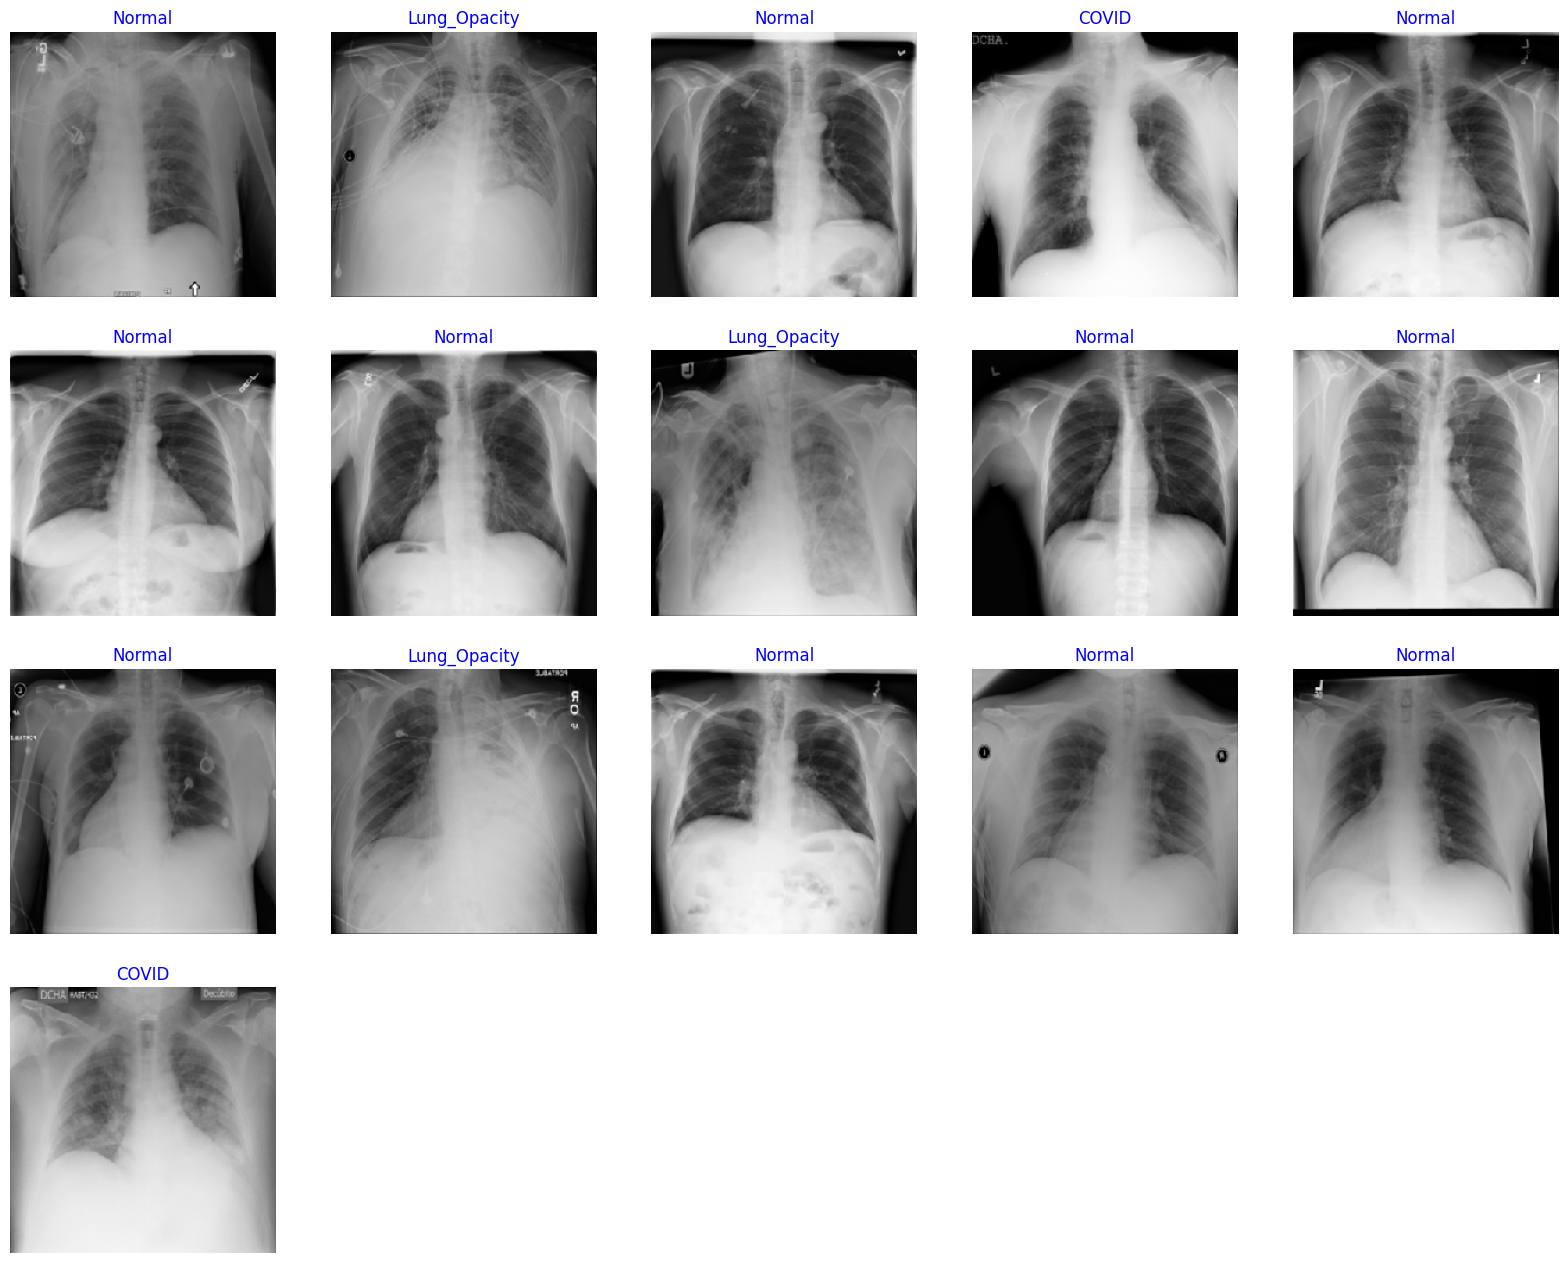

In [8]:
def show_images(gen):
    '''
    This function takes the data generator and shows a sample of the images
    '''
    # return classes, images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's keys (classes), class names : string
    images, labels = next(gen)        # get a batch of samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        # image = (images[i] + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        image = images[i]/255
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

# Usage: show_images(train_gen)
show_images(train_gen)

## Sanity check for class distribution

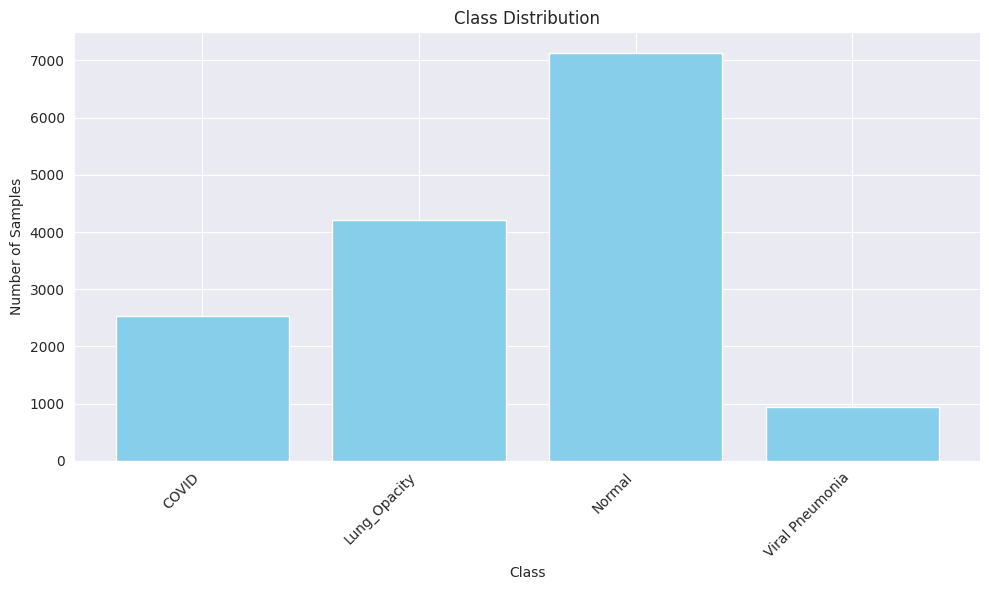

In [9]:
def plot_class_distribution(generator):
    '''
    This function takes a data generator and plots the class distribution (number of samples per class)
    '''
    # Get the class labels and their corresponding indices
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())

    # Count the samples for each class
    class_counts = {class_name: 0 for class_name in class_labels}

    # Loop through the labels and count samples per class
    for label in generator.labels:
        class_name = class_labels[label]  # Get the class name corresponding to the label
        class_counts[class_name] += 1

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# You can call the function like this:
plot_class_distribution(train_gen)


# Model structure, and Training

In [10]:
from keras.applications import MobileNetV3Small
"""
Can try non training if wanting pretrained model only + hidden layers
"""

pre_trained_model = MobileNetV3Small(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet",
    include_preprocessing=True,
    pooling='max'
)

pre_trained_model.summary(show_trainable=True)

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 224,     │         0 │ input_layer[0… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv (Conv2D)     │ (None, 112,     │       432 │ rescaling[0][… │   Y   │
│                   │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv_bn           │ (None, 112,     │        64 │ conv[0][0]     │   Y   │
│ (BatchNormalizat… │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 112,     │         0 │ conv_bn[0][0]  │   -   │
│ (Activation)      │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_de… │ (None, 113,     │         0 │ activation[0]… │   -   │
│ (ZeroPadding2D)   │ 113, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_de… │ (None, 56, 56,  │       144 │ expanded_conv… │   Y   │
│ (DepthwiseConv2D) │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_de… │ (None, 56, 56,  │        64 │ expanded_conv… │   Y   │
│ (BatchNormalizat… │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 56, 56,  │         0 │ expanded_conv… │   -   │
│                   │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_sq… │ (None, 1, 1,    │         0 │ re_lu[0][0]    │   -   │
│ (GlobalAveragePo… │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_sq… │ (None, 1, 1, 8) │       136 │ expanded_conv… │   Y   │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_sq… │ (None, 1, 1, 8) │         0 │ expanded_conv… │   -   │
│ (ReLU)            │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_sq… │ (None, 1, 1,    │       144 │ expanded_conv… │   Y   │
│ (Conv2D)          │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 1, 1,    │         0 │ expanded_conv… │   -   │
│                   │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 1, 1,    │         0 │ add[0][0]      │   -   │
│                   │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ multiply          │ (None, 1, 1,    │         0 │ re_lu_1[0][0]  │   -   │
│ (Multiply)        │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ expanded_conv_sq… │ (None, 56, 56,  │         0 │ re_lu[0][0],   │   - 

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [11]:
def create_model():
    """
    Model structure can be changed, if ONLY if structure is changed for other models
    """
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = pre_trained_model(inputs)
    # x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    # x = tf.keras.layers.Dense(256,
    #                           kernel_regularizer=tf.keras.regularizers.l2(0.016),
    #                           activity_regularizer=tf.keras.regularizers.l1(0.006),
    #                           bias_regularizer=tf.keras.regularizers.l1(0.006),
    #                           activation='relu')(x)
    # x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.66, seed=42)(x)

    outputs = tf.keras.layers.Dense(4,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.016),
                                    activity_regularizer=tf.keras.regularizers.l1(0.006),
                                    bias_regularizer=tf.keras.regularizers.l1(0.006),
                                    activation='softmax')(x)


    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    model.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [12]:
my_model = create_model()
my_model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MobileNetV3Small            │ (None, 576)           │    939,120 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 576)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 4)             │      2,308 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 941,428 (3.59 MB)

 Trainable params: 929,316 (3.55 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [13]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience  # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # factor by which to reduce the learning rate
        self.batches = batches  # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # save this value to restore if restarting training

        # callback variables
        self.count = 0  # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # epoch with the lowest loss
        self.highest_tracc = 0.0  # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # set lowest validation loss to infinity initially
        self.best_weights = None  # placeholder for best weights
        self.initial_weights = None  # placeholder for initial weights

    # Define a function that will run when training begins
    def on_train_begin(self, logs=None):
        msg = 'Do you want model to ask you to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}Processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    # Define method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # Get current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # Get training accuracy
        v_acc = logs.get('val_accuracy')  # Get validation accuracy
        loss = logs.get('loss')  # Get training loss for this epoch
        v_loss = logs.get('val_loss')  # Get the validation loss for this epoch

        if acc < self.threshold:  # If training accuracy is below threshold, adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # Define improvement of model progress

            if acc > self.highest_tracc:  # Training accuracy improved in the epoch
                self.highest_tracc = acc  # Set new highest training accuracy
                self.best_weights = self.model.get_weights()  # Save the weights if training accuracy improved
                self.count = 0  # Reset count to 0 since training accuracy improved
                self.stop_count = 0  # Reset stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # Set the best epoch for this epoch

            else:
                # Training accuracy did not improve, check if this happened for patience number of epochs
                # If so, adjust learning rate
                if self.count >= self.patience - 1:  # Time to adjust the learning rate
                    lr = lr * self.factor  # Reduce the learning rate by the factor
                    # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)  # Set the learning rate
                    self.model.optimizer.learning_rate.assign(lr)
                    self.count = 0  # Reset the count
                    self.stop_count += 1  # Increment the stop count since lr was adjusted
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1  # Increment the patience counter

        else:  # Training accuracy is above threshold, so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:  # Validation loss improved
                self.lowest_vloss = v_loss  # Update lowest validation loss
                self.best_weights = self.model.get_weights()  # Save the weights if validation loss improved
                self.count = 0  # Reset count
                self.stop_count = 0
                self.best_epoch = epoch + 1  # Set the best epoch for this epoch

            else:  # Validation loss did not improve
                if self.count >= self.patience - 1:  # Adjust learning rate
                    lr = lr * self.factor  # Reduce the learning rate by the factor
                    self.stop_count += 1  # Increment stop count since learning rate was adjusted
                    # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)  # Set the new learning rate
                    self.model.optimizer.learning_rate.assign(lr)
                else:
                    self.count += 1  # Increment the patience counter

            if acc > self.highest_tracc:
                self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:  # Stop training after too many learning rate adjustments without improvement
            msg = f'Training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True  # Stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'Enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'Training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True  # Stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'Training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

# Example usage:
batch_size = 16  # set batch size for training
epochs = 25  # number of all epochs in training
patience = 3  # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10  # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # factor to reduce lr by
ask_epoch = 5  # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # number of training batch to run per epoch

# Assuming 'my_model' is your Keras model
callbacks = [MyCallback(patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

In [14]:
history = my_model.fit(train_gen, epochs=epochs, verbose=0, callbacks=callbacks,
                    validation_data=val_gen, validation_steps=None, shuffle= False)

Do you want model to ask you to halt the training [y/n]?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /25     1.111   81.139   8.56531  54.045   0.00100  0.00100  accuracy     0.00    132.97 
 2 /25     0.473   89.476   2.61354  88.711   0.00100  0.00100  accuracy    10.27    70.34  
 3 /25     0.444   90.489   2.46438  80.527   0.00100  0.00100  val_loss     5.71    71.92  
 4 /25     0.425   91.771   1.22723  81.232   0.00100  0.00100  val_loss    50.20    62.23  
 5 /25     0.391   92.622   1.21656  89.911   0.00100  0.00100  val_loss     0.87    61.74  
 6 /25     0.367   92.851   2.53116  87.888   0.00100  0.00100  val_loss   -108.06   61.57  
 7 /25     0.364   93.067   2.72605  72.460   0.00100  0.00100  val_loss   -124.08   62.50  
 8 /25     0.338   94.006   1.55949  87.959   0.00100  0.00050  val_loss    -28.19   61.36  
 9 /25     0.277   95.146   0.41743  93.650   0.00050  0.00050  val_loss    65.69    62.30  
10 /25     0

# Model evaluation and confusion matrix

In [15]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

## Display model pperformance

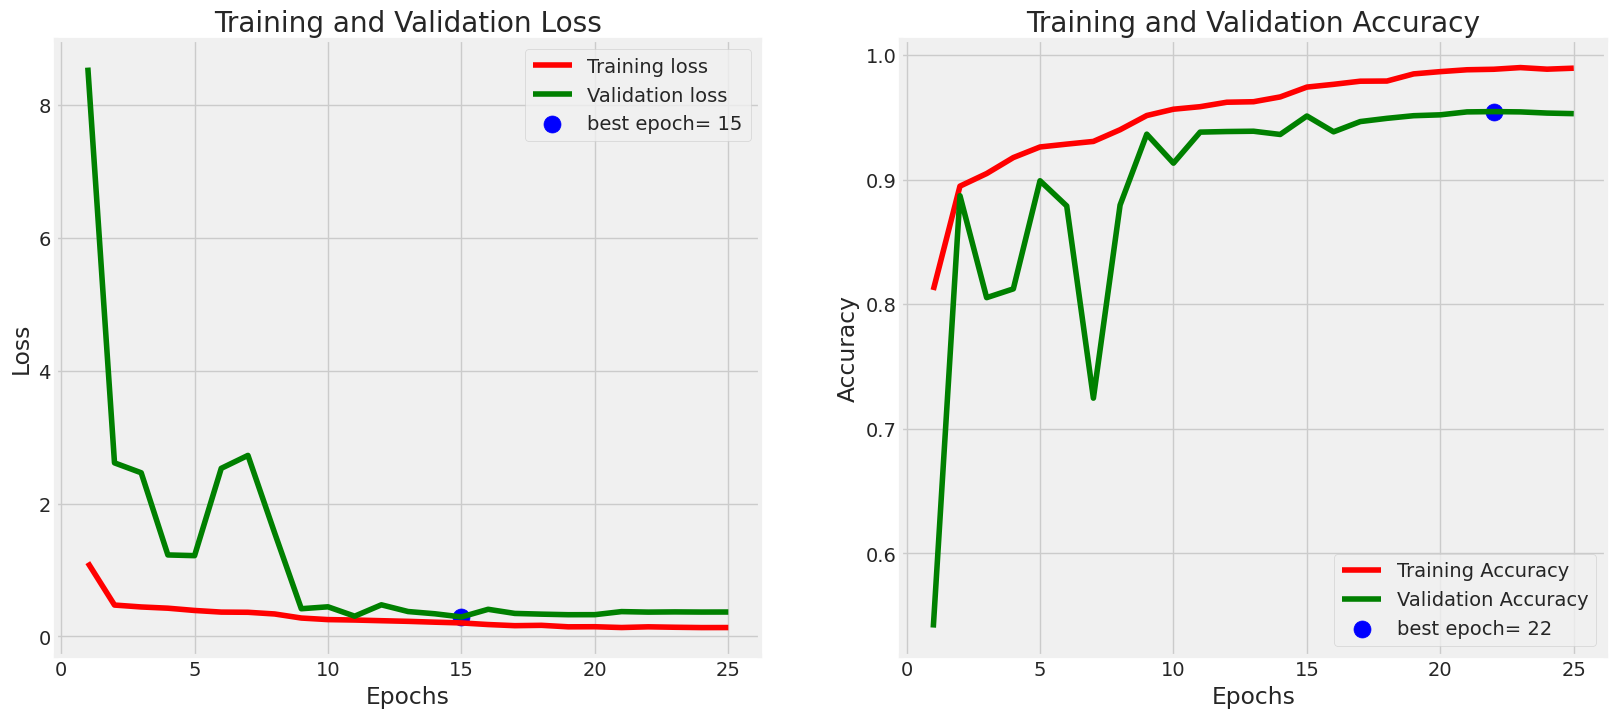

In [16]:
plot_training(history)

## Evaluate model predictions

In [17]:
ts_length = test_gen.samples
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = my_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = my_model.evaluate(val_gen, steps= test_steps, verbose= 1)
test_score = my_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2099/2099 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.9822 - loss: 0.1469 
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9509 - loss: 0.2940  
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9493 - loss: 0.3061  
Train Loss:  0.1483299285173416
Train Accuracy:  0.9817065000534058
--------------------
Validation Loss:  0.29366591572761536
Validation Accuracy:  0.9510818719863892
--------------------
Test Loss:  0.30688905715942383
Test Accuracy:  0.949499785900116


In [18]:
preds = my_model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step
[0 0 0 ... 3 3 3]


In [19]:
print(test_gen.classes)

[0 0 0 ... 3 3 3]


Confusion Matrix, Without Normalization
[[350   3   6   0]
 [  4 534  58   0]
 [  6  23 975   6]
 [  0   0   0 134]]
                 precision    recall  f1-score   support

          COVID       0.97      0.97      0.97       359
   Lung_Opacity       0.95      0.90      0.92       596
         Normal       0.94      0.97      0.95      1010
Viral Pneumonia       0.96      1.00      0.98       134

       accuracy                           0.95      2099
      macro avg       0.96      0.96      0.96      2099
   weighted avg       0.95      0.95      0.95      2099



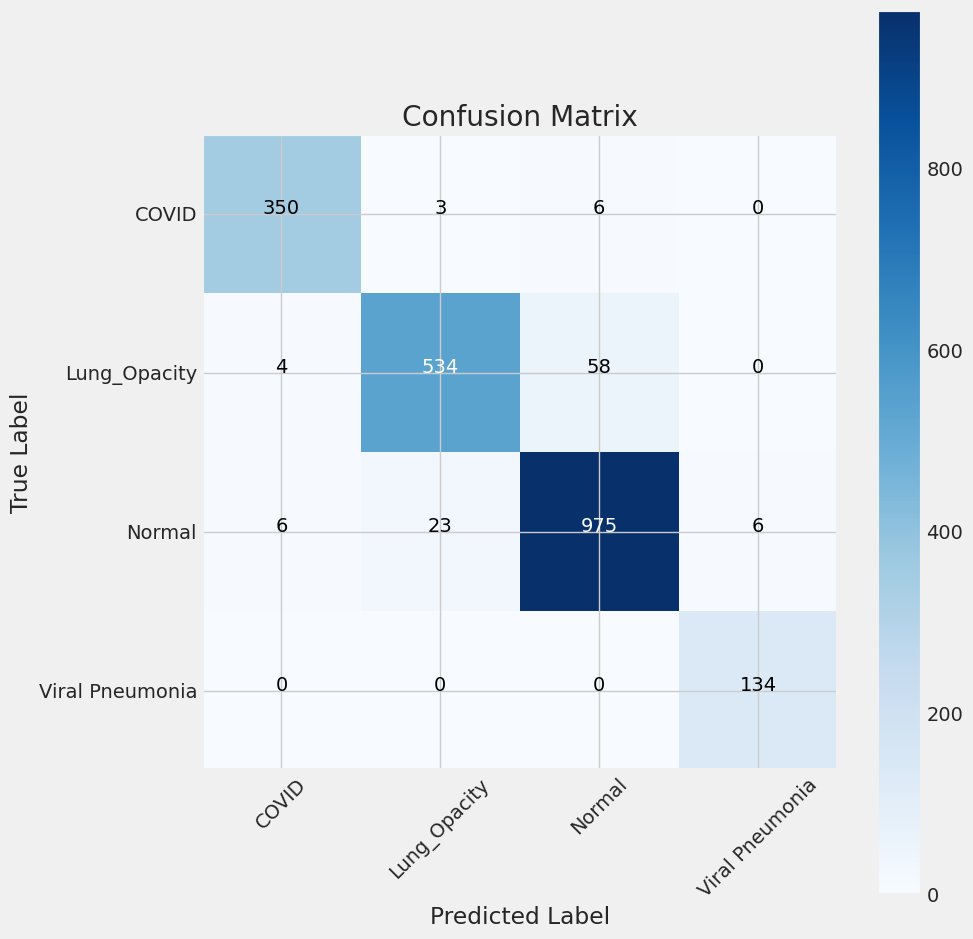

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [21]:
model_name = "mobilenetv3small"
subject = 'COVID-19'
acc = test_score[1] * 100
save_path = ''

# Save my_model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.keras')
my_model_save_loc = os.path.join(save_path, save_id)
my_model.save(my_model_save_loc)
print(f'my_model was saved as {my_model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
my_model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

my_model was saved as mobilenetv3small-COVID-19-94.95.keras
weights were saved as mobilenetv3small-COVID-19-94.95.weights.h5


In [22]:
import os
from google.colab import files
import glob

# Get a list of all .txt files in the current directory
def download(ext):
    txt_files = glob.glob(str(ext))

    # Download each .txt file
    for txt_file in txt_files:
        files.download(txt_file)

    return

download('*.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
download('*.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>